# Exact and efficient Bayesian inference for multiple changepoint problems


Fearnhead, P., 2006. Exact and efficient Bayesian inference for multiple changepoint problems. Statistics and Computing, 16(2), pp.203-213.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as  plt
from functools import partial
from jax.scipy import stats

/Users/gerardoduran/miniforge3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

We define

$$
    P(t, s) = p({\bf y}_{t:s} \vert t,s \text{ are in the same segment}) = \int\prod_{i=t}^s f(y_i\vert\theta)\pi(\theta) d\theta
$$

As well as

$$
\begin{aligned}
    Q(t) &= p(y_{t:T} \vert \text{changepoint at } t-1)\\
         &= \sum_{s=t}^{T-1} P(t,s) Q(s+1) g(s+1-t) + P(t,T)(1 - G(T-t))
\end{aligned}
$$

and
$$
\begin{aligned}
Q(1) &= p({\bf y}_{1:T})\\
     & \sum_{s=1}^{T-1}P(1,s) Q(s+1) g_0(s) + P(1,T)(1 - G_0(n - 1))
\end{aligned}
$$

These are the *building blocks* to compute the posterior distributions

$$
    p(\tau_1 \vert y_{1:T}),
$$

and

$$
    p(\tau_j \vert \tau_{j-1}, y_{1:T})
$$

## Block dataset

$$
    f(t) = \sum_{j} h_j K(t - t_j); \ K(t) = \{1 + \text{sgn}(t)\} / 2
$$

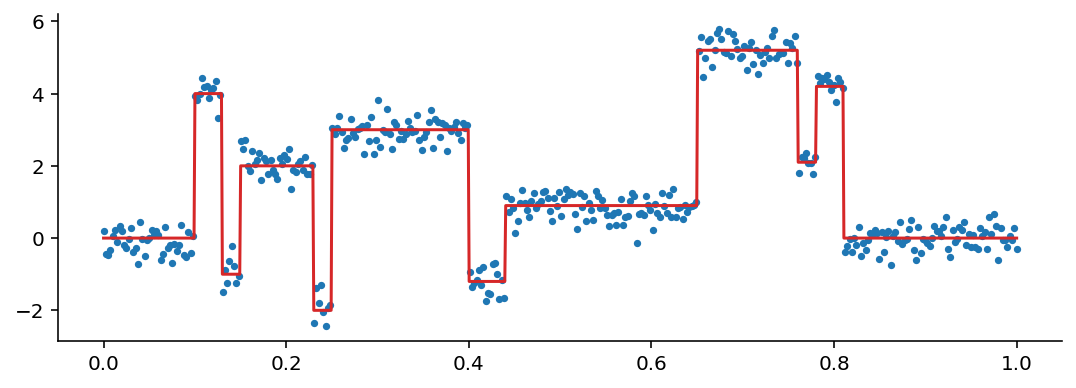

In [316]:
def K(t):
    return (1 + jnp.sign(t)) / 2

def f(t, t_elements, h_elements):
    res = h_elements * K(t - t_elements)
    return res.sum()

t_elements = jnp.array([10, 13, 15, 23, 25, 40, 44, 65, 76, 78, 81]) / 100
h_elements = jnp.array([4, -5, 3, -4, 5, -4.2, 2.1, 4.3, -3.1, 2.1, -4.2])

f_block = partial(f, t_elements=t_elements, h_elements=h_elements)
f_block = jax.vmap(f_block)

T = 1000
t = jnp.linspace(0, 1, T)
y_block = f_block(t)

key = jax.random.PRNGKey(314)
n_obs = 400
t_obs = jnp.linspace(0, 1, n_obs)
y_obs = f_block(t_obs) + jax.random.normal(key, (n_obs,)) / 3
T = len(y_obs)

fig, ax = plt.subplots(figsize=(9, 3))
ax.scatter(t_obs, y_obs, s=7)
ax.plot(t, y_block, c="tab:red")

## Implementation

Timesteps

$$
\begin{aligned}
    Q(T) &= p(y_T)\\
    Q(T-1) &= P(T-1, T-1)Q(T)g(1) + P(T-1, T)(1 - G(1))\\
    Q(T-2) &= P(T-2, T-2)Q(T-1)g(1) + P(T-2, T-1)Q(T) + P(T-2, T)(1 - G(2))\\
    Q(T-3) &= P(T-3, T-3)Q(T-2)g(1) + P(T-3, T-2)Q(T-1)g(2) + P(T-3, T-1)Q(T)g(3) + P(T-3, T)(1 - G(3))
\end{aligned}
$$

In [450]:
mu, sigma = 0, 1.5
theta0, sigma0 = 0, 1


def log_prob_segment(y, t, s):
    """
    P(y{t:s} | t, s in the same segment)
    """
    T = len(y)
    marginal_mean = mu * theta0
    marginal_std = jnp.sqrt(sigma ** 2  + sigma0 ** 2)
    timesteps = jnp.arange(T) + 1
    log_pdf = stats.norm.logpdf(y_obs, loc=marginal_mean, scale=marginal_std)
    log_pdf = log_pdf * (timesteps >= t) * (timesteps <= s)
    return log_pdf.sum() * (t <= s)


log_prob_segment_vmap = jax.vmap(log_prob_segment, in_axes=(None, None, 0))


def log_pmf_changepoint(t, p):
    """
    Probability mass function for the distance
    between two change points, as well as the probability
    mass function for the position of the first change point.
    
    We take the geometric distribution: p * (1 - p) ** (t-1)
    """
    return stats.geom.logpmf(t, p)


def log_cdf_changepoint(T, p):
    """
    Distribution function for the distance between
    two change points
    """
    t_vals = jnp.arange(T) + 1
    vt = stats.geom.logpmf(t_vals, p)
    return jax.nn.logsumexp(vt)
    vstar = vt.max()
    log_cdf = vstar + jnp.log(jnp.exp(vt - v_star).sum())
    return log_cdf


def log_survival_changepoint(log_probs):
    """
    Let x be a random variable with pmf "g". We denote
    its CDF by G(t) = Σi{1,..,t} g(i). The survivial function
    of x is 1 - G(t).
    
    We compute log(1 - sum(exp(log_probs)))
    """
    b = jnp.r_[1, -jnp.ones_like(log_probs)]
    log_survival = jax.nn.logsumexp(jnp.r_[0, log_probs], b=b)
    log_survival = jnp.nan_to_num(log_survival, nan=-jnp.inf)
    return log_survival

In [451]:
# timesteps = jnp.arange(T) + 1

p = 0.025
def log_Q_step(state, t):
    log_Q, ix = state
    
    # log-probabilities and survivial function
    log_g_values = log_pmf_changepoint(timesteps - t, p)[1:]
    log_G_value = log_survival_changepoint(log_g_values)
    
    # Segment log-probability: ∀ s=T,..,1. P(t, s)
    log_Pts = log_prob_segment_vmap(y_obs, t, timesteps)
    log_PtT, log_Pts = log_Pts[-1], log_Pts[:-1]
    
    # previous-segment log-likelihood
    v_terms = log_Pts + log_Q[1:] + log_g_values
    vT = log_PtT + log_G_value
    v_terms = jnp.append(v_terms, vT)
    log_Q_prev = jax.nn.logsumexp(v_terms)
      
    log_Q = log_Q.at[ix].set(log_Q_prev)
    state = log_Q, ix - 1
    return state, None

In [452]:
log_Q_values = jnp.zeros(T)
log_QT = log_prob_segment(y_obs, T, T)

log_Q_values = log_Q_values.at[-1].set(log_QT)

timesteps_prev = jnp.arange(T - 1, 0, -1)
init_state = log_Q_values, -2
(log_Q_values, _), _ = jax.lax.scan(log_Q_step, init_state, timesteps_prev)

Text(0, 0.5, '$y$')

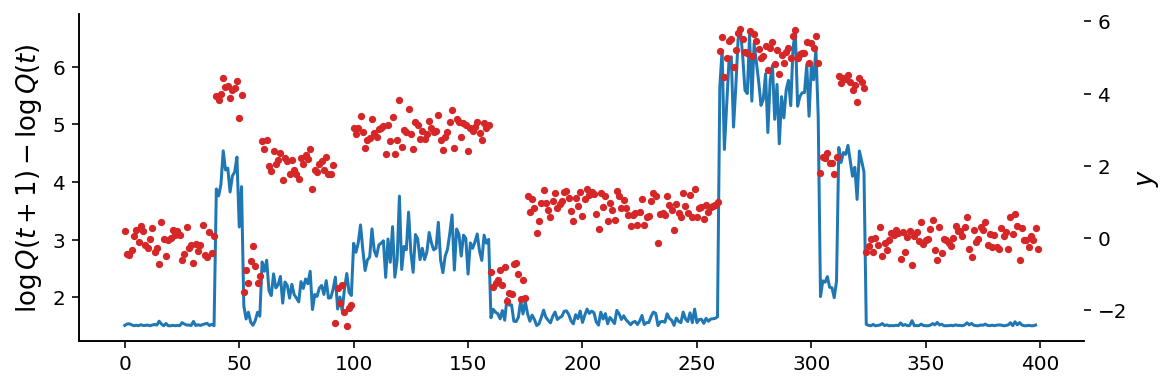

In [578]:
fig, ax = plt.subplots(figsize=(9,3))
ax2 = ax.twinx()
ax.plot(jnp.diff(log_Q_values))
ax2.scatter(jnp.arange(T), y_obs, s=7, c="tab:red")
ax.set_ylabel("$\log Q(t+1) - \log Q(t)$", fontsize=13)
ax2.set_ylabel("$y$", fontsize=13)

In [588]:
log_Q_values[-10:]

DeviceArray([-15.204639 , -13.679987 , -12.116443 , -10.595528 ,
              -9.086752 ,  -7.577939 ,  -6.0611477,  -4.552556 ,
              -3.0436769,  -1.5228941], dtype=float32)

In [587]:
log_Q_values[0]

DeviceArray(-982.87524, dtype=float32)

## Perfect simulation of changepoints

In [561]:
def log_posterior_changepoint(tau, tau_prev=0):
    log_prob = (log_prob_segment(y_obs, tau_prev+1, tau) + log_Q_values[tau] +
                log_pmf_changepoint(tau - tau_prev, p) - log_Q_values[tau_prev])
    return log_prob  + jnp.nan * (tau <= tau_prev)

log_posterior_changepoint = jax.vmap(log_posterior_changepoint, in_axes=(0, None))
# log_posterior_changepoint = jax.vmap(log_posterior_changepoint, in_axes=(None, 0))

In [577]:
log_pred = log_posterior_changepoint(timesteps_eval, 400)
jnp.nansum(jnp.exp(log_pred))

DeviceArray(0., dtype=float32)

In [557]:
log_prob_changepoints = log_pmf_changepoint(timesteps[:-1], p)
log_p_no_changepoint = (log_prob_segment(y_obs, 1, T) +
                        log_survival_changepoint(log_prob_changepoints) -
                        log_Q_values[1])
# Probability of no further changepoint
jnp.exp(log_p_no_changepoint)

DeviceArray(9.052887e-06, dtype=float32)

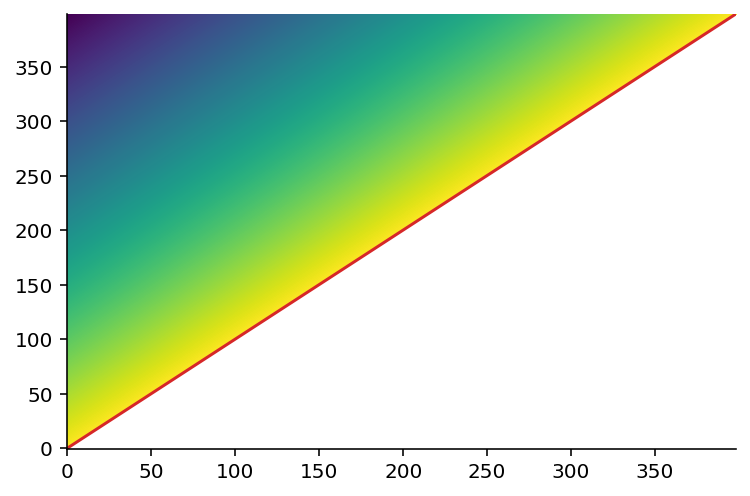

In [505]:
timesteps_eval = timesteps[:-1]
log_pred = log_posterior_changepoint(timesteps_eval, timesteps_eval - 1)
log_pred_argmax = jnp.nanargmax(log_pred, axis=1)

plt.imshow(jnp.rot90(log_pred, k=3)[:, ::-1], origin="lower", aspect="auto", cmap="viridis")
plt.plot(log_pred_argmax, c="tab:red")

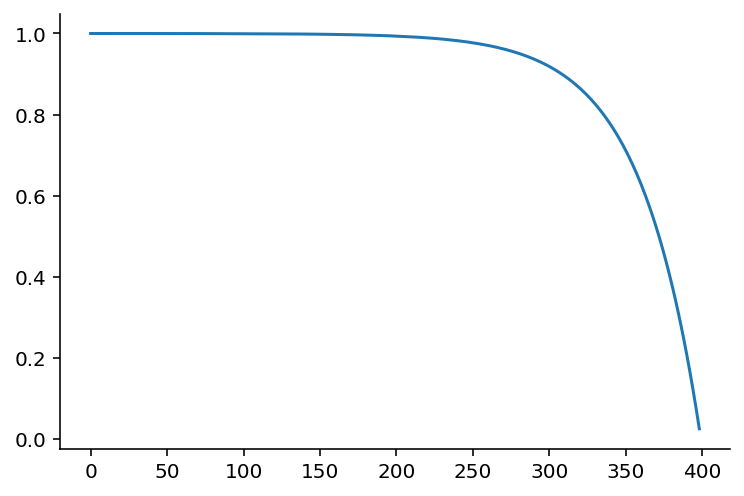

In [506]:
# Check whether all proabbilities sum to one
check_probs = jnp.nansum(jnp.exp(log_pred), axis=1)
plt.plot(check_probs)

In [ ]:
detected_changepoints = jnp.unique(log_pred_argmax)
fig, ax = plt.subplots()
ax.scatter(jnp.arange(T), y_obs, s=7, c="tab:red")
for changepoint in detected_changepoints:
    plt.axvline(x=changepoint, c="tab:gray", alpha=0.5, linestyle="--")